# Приоритизация гипотез и оценка результатов А/В-теста

# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

**Цель исследования**

* Приоритизировать гипотезы, 
* Запуститить A/B-тест 
* Проанализировать результаты. 

## Изучение данных из файла

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
import warnings
from tqdm import tqdm
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 1000) # для выводов всех символов в записях

Открываем файлы

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

#Загрузим библиотеки, которые помогут быстро выполнить разведочный материал

**Получаем общую информацию о таблицах**

In [3]:
hypothesis.info()
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



**Вывод:**

**В нашем распоряжении 3 таблицы:**

1. Hypothesis (Данные для первой части) - 5 столбцов, 9 строк записей, 2 типа данных: int64 и object.

Структура

- `Hypothesis` - краткое описание гипотезы;
- `Reach` - охват пользователей по 10-балльной шкале;
- `Impact` - влияние на пользователей по 10-балльной шкале;
- `Confidence` - уверенность в гипотезе по 10-балльной шкале;
- `Efforts` - затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2. Orders(Данные для второй части) - 5 столбцов, 1197 строк записей, 2 типа данных: int64 и object.

Структура

- `transactionId` - идентификатор заказа;
- `visitorId` - идентификатор пользователя, совершившего заказ;
- `date` - дата, когда был совершён заказ;
- `revenue` - выручка заказа;
- `group` - группа A/B-теста, в которую попал заказ.

3. Visitors(Данные для второй части) - 3 столбца, 62 строки записей, 2 типа данных: int64 и object.

Структура

- `date` - дата;
- `group` - группа A/B-теста;
- `visitors` - количество пользователей в указанную дату в указанной группе A/B-теста.

В названиях колонок видны нарушения стиля:

    Необходимо привести к нижнему регистру столбцы таблицы Hypothesis.

Так же необходимо изменить тип данных в некоторых столбцах в таблицах `orders` и `visitors`.


## Предобработка данных

### Стиль заголовков столбцов

Выведем на экран названия столбцов:

In [6]:
print(hypothesis.columns)
print(orders.columns)
visitors.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Efforts'], dtype='object')
Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')


Index(['date', 'group', 'visitors'], dtype='object')

Приведем названия столбцов таблицы `hypothesis` к нижнему регистру. Трогать DF `orders` не будем, для удобства восприятия

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()

Проверим результат

In [8]:
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

### Замена типа данных

Проинализировав первоначальные данные, придём к результату, что столбцы с датами имеют тип `object`. 

Для дальнейшей работы необходимо изменить их тип на `datetime`

Во всех трёх таблицах есть столбцы с датами, которые имеют тип object, а именно:

**visitors** - `date`

**orders** - `date`

In [9]:
#Замена типа данных для visitors['date']
visitors['date'] = pd.to_datetime(visitors['date'])
#Проверим
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [10]:
#Замена типа данных для orders['date']
orders['date'] = pd.to_datetime(orders['date'])
#Проверим
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


### Дубликаты и пропуски

**Проверим таблицы на отстутствие дубликатов:**

In [11]:
print(hypothesis.duplicated().sum())
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0
0


Дубликаты отсуствуют

**Проверим таблицы на наличие пропусков**

In [12]:
print(hypothesis.isna().sum())
print(orders.isna().sum())
print(visitors.isna().sum())

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
date        0
group       0
visitors    0
dtype: int64


Пропуски отсуствуют

**Проверим, наличие пользователей, которые попали в 2 теста одновременно**

In [13]:
users_two_group = orders.groupby('visitorId').agg({'group':'nunique'})
users_two_group = users_two_group.query('group > 1')
users_two_group['group'].count()

58

58 покупателей находятся одновременно в двух группах А/В теста

**Вывод:**

Провели предобработку и подготовили наши данные к дальнейшему исследованию.

А именно:

 - Исправили заголовки столбцов и привели их к "хорошему" стилю
 - Изменили тип данных во всех трёх таблицах в столбцах с датами
 - Проверили таблицы на наличие дубликатов (дубликатов нет)

## Приоритизация гипотез.

### Фреймворк ICE.

`ICE`(усиление/простота) - один из самых популярных способов приоритизации задач

In [14]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [15]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence']) / hypothesis['efforts']   

In [16]:
hice =  hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False).round(0)
hice

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


### Фреймворк RICE.

RICE — это метод приоритизации идей и фич продукта. Аббревиатура включает 4 фактора, которые менеджер продукта может смело использовать для оценки и приоритизации продуктовых фич:

- Reach — это охват
- Impact — влияние
- Confidence — уверенность в вашей оценке охвата, влияния и трудозатрат
- Effort — трудозатраты

In [17]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [18]:
hrice = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending = False).round(0)
hrice

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [19]:
unification = hice.merge(hrice, on = 'hypothesis') # объединили

cm = sns.light_palette("green", as_cmap=True) #выделили цветом
unification.style.background_gradient(cmap=cm)

,hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16,16
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13,40
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11,112
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1,4
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1,9
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3


### Причины изменения приоритизация гипотез.

Мы применили один из самых популярных способов приоритизации задач `ICE`(«влияние, уверенность, усилия / простота») и его модификатор `RICE`(«охват»).

После применения флейморка `ICE` наиболее перспективными гипотезами являются:
 - Запустить акцию, дающую скидку на товар в день рождения (8)
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (0)	
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (7)

После применения флейморка RICE наиболее перспективными гипотезами являются:
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (7)
 - 	Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (2)
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (0)

Исходя из вышеизложенного, рекомендуется в первую очередь протестировать гипотезы:
 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (Порядковый номер 7)
 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (Подярковый номер 0)

## Анализ A/B-теста

### График кумулятивной выручки по группам

In [20]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [21]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

Этот код работает так, будто мы ежедневно считали результаты тестирования до выбранного дня включительно и сохраняли их в строках таблицы `ordersAggregated`, содержащую такие столбцы:

- дату;
- группу A/B-теста;
- число уникальных заказов в группе теста по указанную дату включительно;
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
- суммарную выручку заказов в группе теста по указанную дату включительно.

Объявим переменную `visitorsAggregated`, содержащую:

- дату;
- группу A/B-теста;
- количество уникальных посетителей в группе теста по указанную дату включительно.

In [22]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

Определим переменную `cumulativeData`, объединив `ordersAggregated` и `visitorsAggregated` по колонкам 'date', 'group' методом merge()

In [23]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

Присвоим столбцам `cumulativeData` названия ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [24]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


**Все нужные кумулятивные данные собраны. Приступаем к построению графиков.**

Объявим переменные `cumulativeRevenueA` и `cumulativeRevenueB`, в которых сохраните данные о датах, выручке и числе заказов в группах A и B.

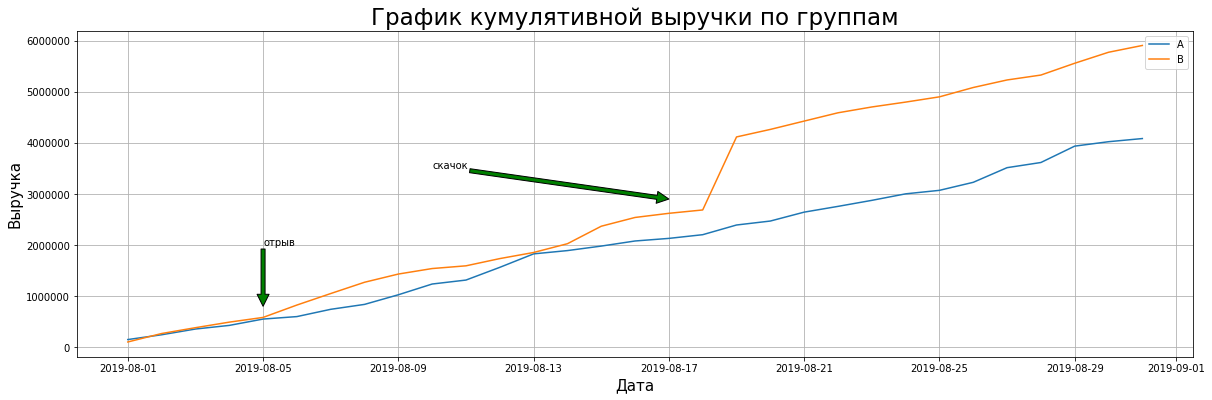

In [25]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

plt.figure(figsize=(20,6))

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.annotate('скачок', xy=('2019-08-17', 2900000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам', size=23)
plt.xlabel("Дата", size=15)
plt.ylabel("Выручка", size=15)
plt.legend()
plt.grid()
plt.show()

До 18.08.2019 выручка почти равномерно увеличивается. Далее наблюдаем реpкий скачок группы В (всплеск числа заказов, либо о появление очень дорогих заказов в наших данных).

### График кумулятивного среднего чека по группам.

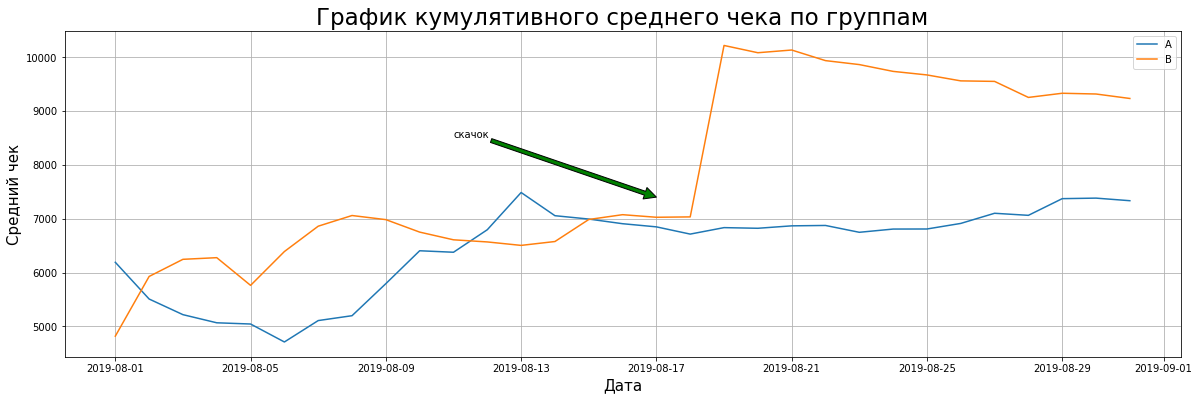

In [26]:
plt.figure(figsize=(20,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')


plt.annotate('скачок', xy=('2019-08-17', 7400), xytext=('2019-08-11', 8500),
            arrowprops=dict(facecolor='g'))

plt.legend()
plt.title('График кумулятивного среднего чека по группам', size=23)
plt.xlabel("Дата", size=15)
plt.ylabel("Средний чек", size=15)
plt.legend()
plt.grid()
plt.show();

Так же, как и в предыдущем графике, средний чек у обоих групп выравнивается к 18.08.2019. Далее после резкого скачка у группы В наблюдаем стабильное уменьшение среднего чека.

Группе В нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на своём реальном уровне

### График относительного изменения кумулятивного среднего чека группы B к группе A.

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом `axhline()` ( «горизонтальная линия поперек оси»):

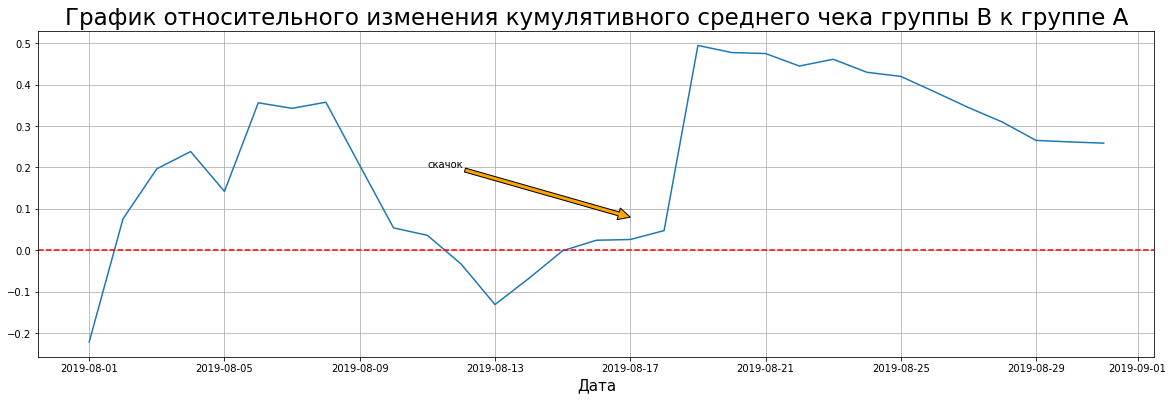

In [27]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(20,6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)


plt.annotate('скачок', xy=('2019-08-17', 0.08), xytext=('2019-08-11', 0.2),
            arrowprops=dict(facecolor='orange'))


# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=23)
plt.xlabel("Дата", size=15)
plt.grid()
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы!

### График кумулятивной конверсии по группам.

Сперва найдём пминамальную и максимальную дату:

In [28]:
print(mergedCumulativeRevenue['date'].min())
print(mergedCumulativeRevenue['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей методом `plt.axis()`. Передадим ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y — ["2019-08-01", '2019-08-31', 0.029, 0.037]:

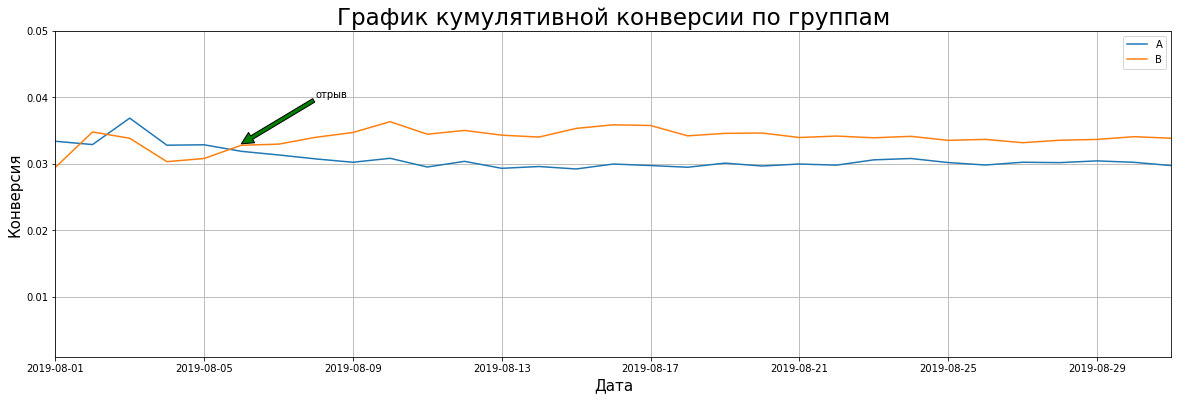

In [29]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


# строим графики
plt.figure(figsize=(20,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.annotate('отрыв', xy=('2019-08-06', 0.033), xytext=('2019-08-08', 0.04),
            arrowprops=dict(facecolor='g')) 


# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.001, 0.05])
plt.title('График кумулятивной конверсии по группам', size=23)
plt.xlabel("Дата", size=15)
plt.ylabel("Конверсия", size=15)
plt.legend()
plt.grid()
plt.show()

До 5 августа данные колебаются вокруг одного значения. Но затем конверсия группы В вырывается в лидеры и фиксируется около одного значения. Так же по группе А - с 9 Августа она зафиксировалась на одном значении (примерно 0.03)

### График относительного изменения кумулятивной конверсии группы B к группе A.

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on = 'date', right_on='date', how = 'left', suffixes = ['A', 'B'])

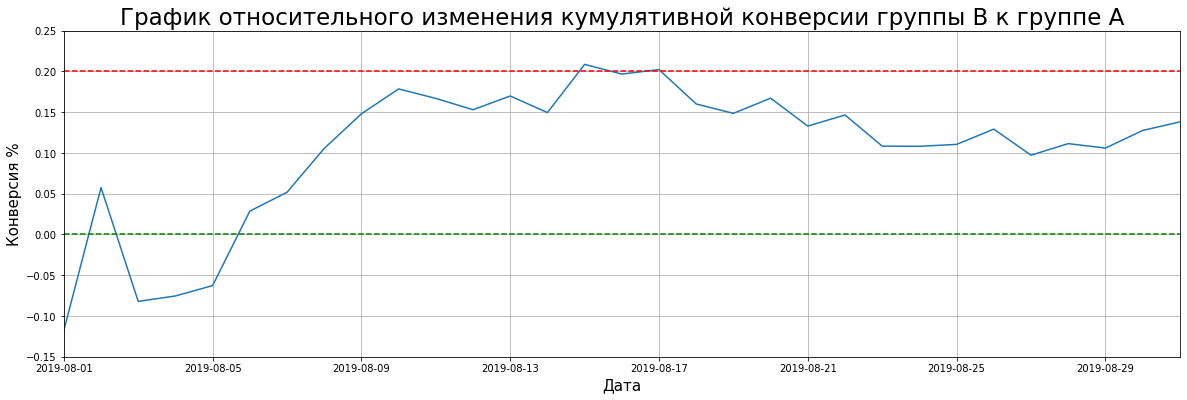

In [31]:
plt.figure(figsize=(20,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")


plt.axhline(y=0, color='green', linestyle='--')
plt.axhline(y=0.2, color='red', linestyle='--')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.15, 0.25])
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size=23)
plt.xlabel("Дата", size=15)
plt.ylabel("Конверсия %", size=15)
plt.grid()
plt.show()

С самого начала группа В лидирует в конверсии, но достигнув отметки 20% стала немного регрессировать и зафиксировалась в отметке примерно 12-13% относительно группы А.

### График количества заказов по пользователям.

Найдём число заказов по пользователям — создим датафрейм c двумя столбцами: `'userId'` и `'orders'`. Назовиём его `ordersByUsers`

In [32]:
ordersByUsers  = orders.drop(['group', 'revenue', 'date'], 
                             axis=1).groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.sort_values('orders')

,userId,orders
0,5114589,1
656,2705308997,1
658,2710193528,1
659,2710478747,1
660,2710492161,1
...,...,...
897,3717692402,5
487,2038680547,8
569,2378935119,9
1023,4256040402,11


Построим гистограмму распледеления:

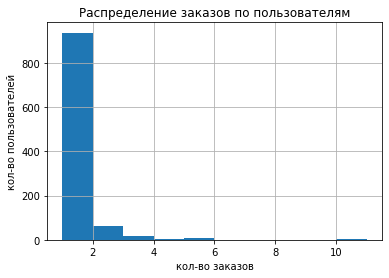

In [33]:
plt.hist(ordersByUsers['orders'])
plt.grid()
plt.title('Распределение заказов по пользователям')
plt.xlabel('кол-во заказов')
plt.ylabel('кол-во пользователей')
plt.show()

Большинство пользователей совершило всего 1 заказ. Однако не ясно, сколько пользователей заказало 2, 3 и более раза. Построим график другого вида

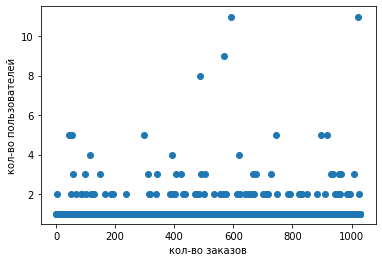

In [34]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('кол-во заказов')
plt.ylabel('кол-во пользователей')
plt.show()

Пользователей, заказавших более 2ух раз совсем мало. Они вполне могут быть аномальными.

### Перцентили количества заказов на пользователя.

Чтобы понять: 2 заказа это много или мало? Нужно посчитать выборочные перцентили

In [35]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали более 2 заказов, и не более 1% - больше 4 заказов

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

Построим гистограмму распределения выручек (`'revenue'`) с заказов по пользователям методом hist().

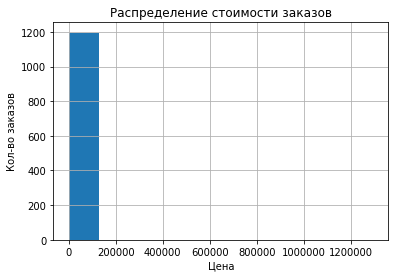

In [36]:
plt.hist(orders['revenue'])
plt.grid()
plt.title('Распределение стоимости заказов')
plt.xlabel('Цена')
plt.ylabel('Кол-во заказов')
plt.show()

Сумма большинства заказов менее 20 000 рублей. Однако по гистограмме ничего не сказать, о распределении более дорогих заказов. Постоим точечный график

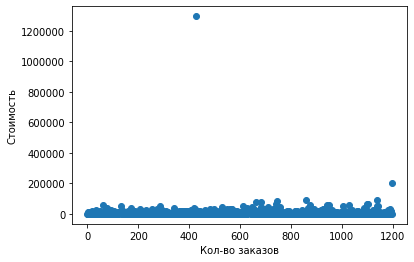

In [37]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Кол-во заказов')
plt.ylabel('Стоимость')
plt.show()

Заказов стоимостью юолее 120000 рублей, не очень много. Выбросов мало, наблюдаем их около 20 000 рублей и выше. Найдём выборочные перцентили

### Перцентили стоимости заказов.

In [38]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более, чем у  5% заказов чек дороже 28 000 рублей. И не больше, чем у 1% - дороже 58233 рубля

### Подсчёт статистической значимости различий в конверсии между группами по «сырым» данным.

Первым делом составим нулевую и альтернативную гипотезы.

H₀(нулевая гипотеза) всегда формулируется так, что иcпользовать знак равенства(=).

 - H₀ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A равна 50%
 - H₁ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A не равна 50%

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

In [39]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

In [40]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [41]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')


sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [42]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [43]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.00840
0.138


P-value значиительно меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ "сырых" данных сообщает, что в конверсии между группами есть статистически значимые различия. Отдельный прирост конверсии группы В к конверсии группы А равен 13.8% (нулевая гипотеза всегда приравнивает, значит Н1 - статистически значимые различий в группах имеются)

### Подсчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

 - H₀ - Средний чек A равен среднему чеку группы B
 - H₁ - Средний чек A  НЕ равен среднему чеку группы B

Посчитаем статистическую значимость различия средних чеков между группами.

Выведем p-value для сравнения средних чеков между группами.

Выведем относительный прирост среднего чека группы B.

In [44]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


P-value больше 0.05 - статистически значимых отличий в среднем чеке между группами нету. Принимаем гипотезу.  


Кроме того, относительное различие среднего чека между сегментами = 25.9%, это много. Вероятнее всего, тут аномалии с двух сторон, с которыми следует поработать.

### Очистка данных

95 и 99 перцентили средних чеков равны 28000 и 58233 рублям. 95 и 99 перцентили числа заказов на одного

Примем за аномальных пользователей тех, кто совершил более 2 заказа и более или совершил заказ на сумму свыше 28 000 рублей.

Сначала определить аномальные заказы, затем пользователей, совершивших их и добавим их в список аномальных.


In [45]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

In [46]:
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

In [47]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [48]:
print(abnormalUsers.head())

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64


In [49]:
#Посчитаем кол-во аномальных юзеров
abnormalUsers.shape

(74,)

Мы нашли 74 аномальных пользователя. Псле их удаления посчитаем стат. значимость. Выясним, если ли разница до/после очищения от аномальний

### Подсчёт статистической значимоси различий в конверсии между группами по «очищенным» данным.

 - H₀ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A равна 50%
 - H₁ - Вероятность того, что наблюдение из популяции B превышает наблюдение из популяции A не равна 50%

Выясним, есть ли существенные различия межу группами с очищенными данными

Посчитаем статистическую значимость различия средних чеков после удаления аномальных пользователей.

**Объявим переменные `sampleAFiltered` и `sampleBFiltered`, в которых сохраним очищенные данные о заказах — не включая аномальных пользователей.**

In [50]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [51]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.00652
0.173


Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент `В` значительно лучше сегмента `А`. Отвергаем H₀

### Подсчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

 - H₀ - Средний чек A равен среднему чеку группы B
 - H₁ - Средний чек A  НЕ равен среднему чеку группы B

In [52]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], 
            True, # что бы задать 4ый параметр 
            'two-sided' # для двух-стороннего теста
        )[1]
    )
)

0.738


In [53]:


print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

-0.020


После очистки данных от аномалий p-value по среднему чеку не изменился т.е. статистически значимых отличий между группами нет. Относительное различие группы В относительно группы А, после очистки данных упало на 27.9%. И составляет всего 2% в пользу группы А. Отвергаем нулевую гипотезу

## Выводы А/В теста

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- Как по сырым, так и по отфильтрованным данным - нет статистически значимого различия по среднему чеку между группами

**График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения (в 13%)**

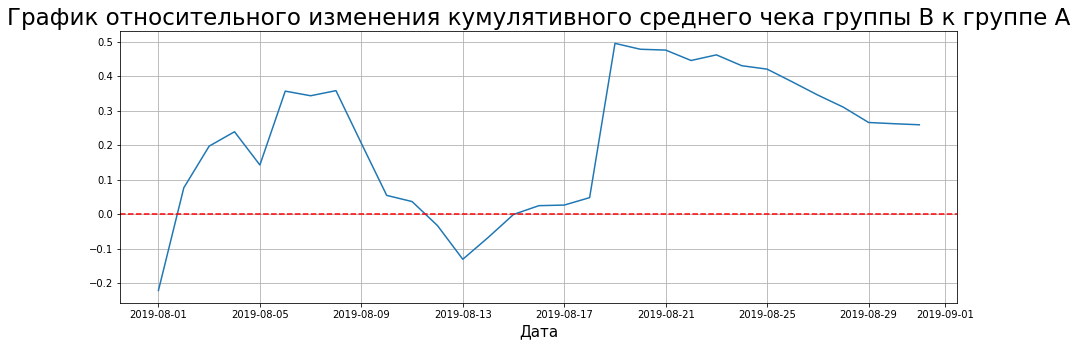

In [54]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=23)
plt.xlabel("Дата", size=15)
plt.grid()
plt.show()

**График различия среднего чека колеблется: он-то и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.**

**При работе с дасетом были выполнены следующие действия:**



1. Загрузили данные и предварительно с ними ознакомились.

2. Провели предобработку данных, а именно:
 - Исправили заголовки столбцов и привели их к "хорошему" стилю
 - Изменили тип данных во всех трёх таблицах в столбцах с датами
 - Проверили таблицы на наличие дубликатов (дубликатов нет)
 - Проверили таблицы на наличие пропусков (пропуски отсутствуют)

3. Провели приоритизацию гипотез:
 - Применили флеймворк `ICE`
 - Применили флеймворк `RICE`
 - Указали, как изменилась приоритизация гипотез
 
4. Провери анализ А/В теста, а именно:
 - Построили график кумулятивной выручки по группам
 - Построили график кумулятивного среднего чека по группам
 - Построили график относительного изменения кумулятивного среднего чека группы B к группе A
 - Построили график кумулятивной конверсии по группам. Сделайте выводы и предположения.
 - Построили график относительного изменения кумулятивной конверсии группы B к группе A.
 - Построили точечный график количества заказов по пользователям
 - Посчитали перцентили количества заказов на пользователя
 - Построили точечный график стоимостей заказов
 - Посчитали перцентили стоимости заказов
 - Посчитали статистическую значимость различий в конверсии между группами по «сырым» данным
 - Посчитали статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
 - Произвели "осчистку" данных от аномалий
 - Посчитали статистическую значимость различий в конверсии между группами по «очищенным» данным
 - Посчитали статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным


**Общий итог.**
 

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.


- Как по сырым, так и по отфильтрованным данным - нет статистически значимого различия по среднему чеку между группами (раз p-value больше уровня значимости, то никаких отличий между группами нет. Выигрыш группы А в данном случае просто шум, случайность).


- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения (в 13%), после удаления аномалий - 17.3%


После очистки данных от аномалий - конверсия так же стат значима (17%).  А разницы в чеках так же нету. Так бывает - пользователи могут начать покупать чаще, но, например, делать более мелкие покупки.

**Исходя из обнаруженных фактов, тест следует остановить (Значения комулятивных метрик стабилизировались более менее) и признать его успешным. Средний чек не поменялся, а конверсия выросла. Группа В лучше чем А, т.к. конверсия больше, при одинаковом среднем чеке, соответственно группа В приносит больше денежных средств бизнесу. Перейти к проверке следующей гипотезы**